# Preface

#### **Dataset Overview:**
The dataset, available [here](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data), provides detailed information on multivariate time series from a fleet of engines. It involves training and test subsets with each engine having varying initial wear and manufacturing conditions.

#### **Original Goal vs. Project Goal:**
Initially designed for predicting Remaining Useful Life (RUL), the project transforms it into a multi-class classification task. The focus shifts to predicting engine health conditions with labels representing early degradation, moderate degradation, and a warning condition.
The project simplifies the complex task of predicting engine health into a classification problem. The three distinct labels facilitate easier interpretation and modeling, focusing on identifying the health condition of each engine in the fleet.

#### **Classification Labels:**
The classification problem simplifies the task into three labels: **Good Condition** **(LR <= 0.6)**, **Moderate Condition** **(0.6 < LR <= 0.8)**, and **Warning Condition** **(LR > 0.8)**. These labels categorize engine health based on Life Ratio (LR) derived from sensor data and operational conditions.

#### **Approach to Classification:**
Employing CatBoost initially, the project aims to fine-tune its performance. Future plans involve incorporating deep learning methods for comparison, enhancing the classification model's effectiveness in predicting engine health conditions

In [1]:
import math
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

# **EDA --Feature Selection**

#### **Dataset Structure Overview:**
The dataset, organized into four sets FD001 to FD004 (each already split into training sets and test sets), comprises time series snapshots with 26 columns, including operational settings, sensor measurements, and unit information. Conditions vary, such as Sea Level or SIX conditions, and fault modes include HPC and Fan Degradation. More info on Dataset can be found [here](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data).

#### **EDA Process:**
Opened and transformed a dataset from a .txt file into a Pandas dataframe, identified and handled missing values, added a header row based on research paper insights. Further analysis revealed two blank columns, which were removed. Statistically assessing the dataset, columns with zero variance and those providing minimal information were excluded. A correlation matrix guided the removal of additional 4 columns,**optimizing the dataset for subsequent machine learning tasks.**

#### **Feature Engineering for Classification:**
Transformed the dataset to 15 columns, retaining the unit number for additional feature incorporation into the classification problem. Introduced a label column based on Life Ratio (LR), with LR=0 signifying the initial degradation phase, and LR=1 indicating EOL. The label column is assigned values (0, 1, 2) for categorizing the health condition, **simplifying the problem into a classification task**.



In [2]:
path = "/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt"

eda_trainset1 = pd.read_csv(path, sep=" ", header=None)

eda_trainset1.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


<Axes: >

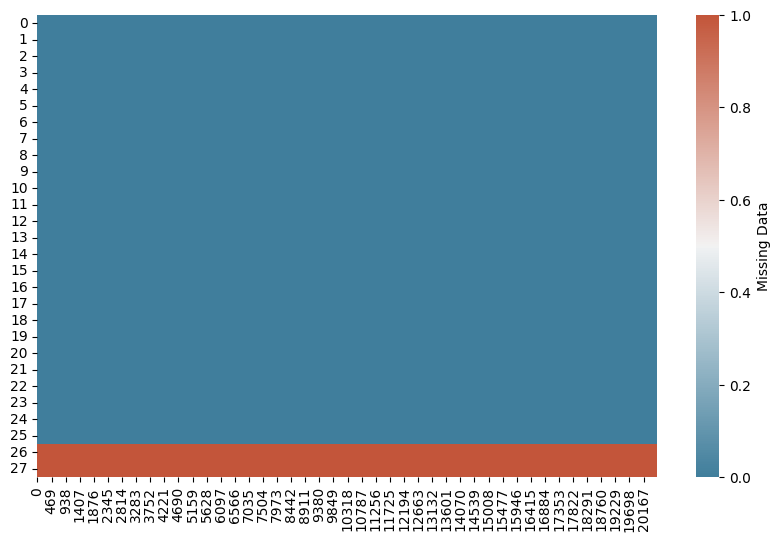

In [3]:
plt.figure(figsize=(10,6))
sns.heatmap(eda_trainset1.isna().transpose(),
            cmap = sns.diverging_palette(230, 20, as_cmap=True),
            cbar_kws={'label': 'Missing Data'})

In [4]:
eda_trainset1.isna().sum()

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    20631
27    20631
dtype: int64

we need to remove the columns indexed at 26 & 27

In [5]:
trainset1_copy = eda_trainset1.drop([26,27], axis=1)

In [6]:
column_names = ["unit_number","time_in_cycles","setting1","setting2","setting3",
                "s01","s02",
                "s03","s04",
                "s05","s06",
                "s07","s08",
                "s09","s10",
                "s11","s12",
                "s13","s14",
                "s15","s16",
                "s17","s18",
                "s19","s20",
                "s21"]

trainset1_copy.columns = column_names
trainset1_copy.head()

,unit_number,time_in_cycles,setting1,setting2,setting3,s01,s02,s03,s04,s05,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
trainset1_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_in_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s01,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s02,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s03,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s04,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s05,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


"s19","s18","s16","s10","s05","s01","setting3" columns show low std and mean == min/max --they wont help in training

In [8]:
trainset1_copy = trainset1_copy.drop(["s19","s18","s16","s10","s05","s01","setting3"], axis=1)

<Axes: >

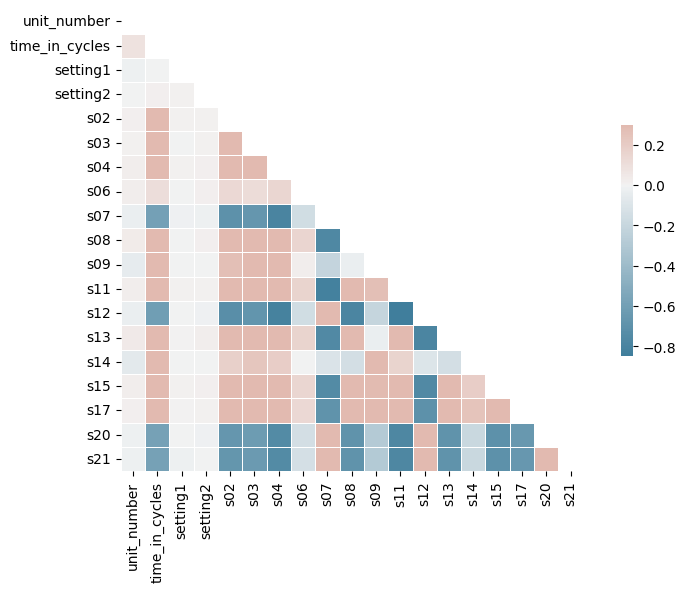

In [9]:
corr = trainset1_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
trainset1_copy = trainset1_copy.drop(["setting1","setting2","s06", "s14"], axis=1) #unit_number will be removed later

In [11]:
# Making an array which contains EOL of all the Ids
EOL=[]
for i in trainset1_copy['unit_number']:
        EOL.append( ((trainset1_copy[trainset1_copy['unit_number'] == i]["time_in_cycles"]).values)[-1])
        
trainset1_copy["EOL"]=EOL

# Calculate "LR"
trainset1_copy["LR"] = trainset1_copy["time_in_cycles"].div(trainset1_copy["EOL"])

trainset1_copy['label'] = pd.cut(trainset1_copy['LR'], bins=[0, 0.6, 0.8, np.inf], labels=[0, 1, 2], right=False)

trainset1_copy.drop(columns=['unit_number', 'EOL', 'LR'], inplace=True)

trainset1_copy.head()

,time_in_cycles,s02,s03,s04,s07,s08,s09,s11,s12,s13,s15,s17,s20,s21,label
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,0
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,0
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,0
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,0
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,0


# Setting Up Evaluation Methods

In [12]:
def score_func(y_true,y_pred):
    """
    model evaluation function
    
    Args:
        y_true = true target RUL value
        y_pred = predicted target RUL value
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    score_list = [round(mae, 2), round(rmse, 2), round(r2, 2)]
    # printing metrics
    print("Classification Report:\n", report)
    print(f' Mean Absolute Error (MAE): {score_list[0]}')
    print(f' Root Mean Squared Error (RMSE): {score_list[1]}')
    print(f' R2 Score: {score_list[2]}')
    print("<)-------------X-------------(>")

In [13]:
def plot_confmatrix(y_true,y_pred):
    confm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(confm, index=sorted(set(y_true)), columns=sorted(set(y_true)))
    
    return sns.heatmap(df_cm, cmap = sns.diverging_palette(230, 20, as_cmap=True) , annot=True, fmt='d')

# DATA MANAGEMENT

In [14]:
def transform_df(file_path):
    # Read CSV file into a DataFrame
    df = pd.read_csv(file_path, sep=" ", header=None)
    df = df.drop([26,27], axis=1)
    column_names = ["unit_number","time_in_cycles","setting1","setting2","setting3",
                "s01","s02","s03","s04","s05","s06","s07","s08","s09","s10","s11","s12","s13",
                "s14","s15","s16","s17","s18","s19","s20","s21"]

    df.columns = column_names
    # Drop specified columns
    columns_to_drop = ["s19", "s18", "s16", "s10", "s05", "s01", "setting3",
                       "setting1", "setting2", "s06", "s14"]
    df = df.drop(columns=columns_to_drop, axis=1)

    # Making an array which contains EOL of all the Ids
    EOL = []
    for i in df['unit_number']:
        EOL.append(((df[df['unit_number'] == i]['time_in_cycles']).values)[-1])

    df["EOL"] = EOL

    # Calculate "LR"
    df["LR"] = df["time_in_cycles"].div(df["EOL"])

    # Create 'label' column
    bins = [0, 0.6, 0.8, np.inf]
    labels = [0, 1, 2]
    df['label'] = pd.cut(df['LR'], bins=bins, labels=labels, right=False)

    # Drop unnecessary columns
    df.drop(columns=['unit_number', 'EOL', 'LR'], inplace=True)

    X_train = df.drop(["label"], axis=1).values
    y_train = df["label"] 

    return X_train, y_train

# **ML**

In [15]:
trainset_path = "/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt"
X_train, y_train = transform_df(trainset_path)
print(f"Dimension of feature matrix : {X_train.shape}\ndimension of target vector: {y_train.shape}")

Dimension of feature matrix : (20631, 14)
dimension of target vector: (20631,)


In [16]:
testset_path ="/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt"
X_test, y_test = transform_df(testset_path)
print(f"Dimension of feature matrix : {X_train.shape}\ndimension of target vector: {y_train.shape}")

Dimension of feature matrix : (20631, 14)
dimension of target vector: (20631,)


## Default Run Analysis

- **Validation Set Performance**: The model performs well on the validation set, indicating that it has learned patterns from the training data.

- **Test Set Performance**: The drop in performance on the test set suggests potential overfitting to the training/validation set. The model might be too complex and capturing noise in the training data.

### Training : Default

In [17]:
X_train_def, X_val_def, y_train_def, y_val_def = train_test_split(X_train, y_train, test_size=0.30, random_state=7)

In [18]:
model = CatBoostClassifier(iterations=100,
                           loss_function="MultiClass",
                           classes_count=3,
                           verbose=False)

# Fit model on training data
model.fit(X_train_def, y_train_def)

### Evaluation on Validation set

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      3699
           1       0.71      0.70      0.71      1247
           2       0.90      0.88      0.89      1244

    accuracy                           0.88      6190
   macro avg       0.85      0.84      0.84      6190
weighted avg       0.88      0.88      0.88      6190

 Mean Absolute Error (MAE): 0.12
 Root Mean Squared Error (RMSE): 0.35
 R2 Score: 0.81
<)-------------X-------------(>


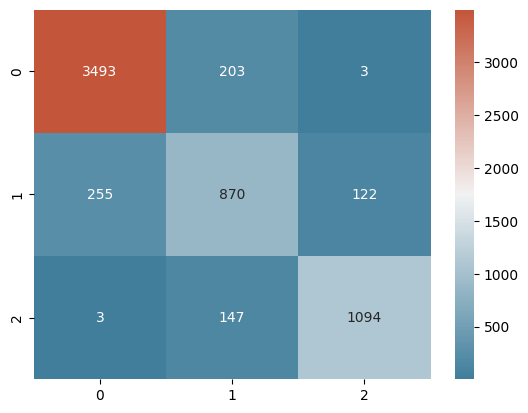

In [19]:
y_pred_def1 = model.predict(X_val_def)
 
# Evaluate the model & print metrics
plot_confmatrix(y_val_def,y_pred_def1)
score_func(y_val_def,y_pred_def1)

### Evaluation on Test set

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.99      0.83      7797
           1       0.33      0.23      0.27      2620
           2       0.97      0.19      0.31      2679

    accuracy                           0.67     13096
   macro avg       0.67      0.47      0.47     13096
weighted avg       0.69      0.67      0.61     13096

 Mean Absolute Error (MAE): 0.41
 Root Mean Squared Error (RMSE): 0.75
 R2 Score: 0.12
<)-------------X-------------(>


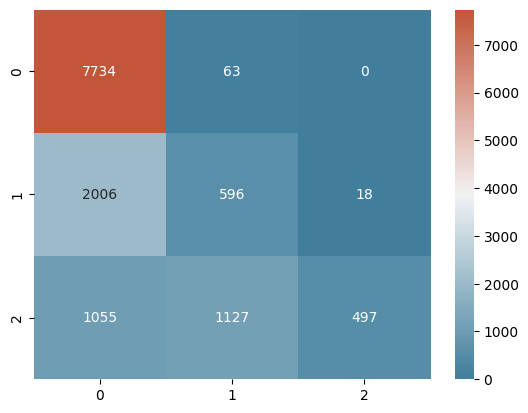

In [20]:
y_pred_def2 = model.predict(X_test)
 
# Evaluate the model & print metrics
plot_confmatrix(y_test,y_pred_def2)
score_func(y_test,y_pred_def2)

# Trying out Recommendations

- **Feature Importance Analysis**

- **Hyperparameter Tuning**: Use techniques like cross-validation and hyperparameter tuning (GridSearchCV or RandomizedSearchCV) to find better hyperparameter values.





### Feature Importance Analysis

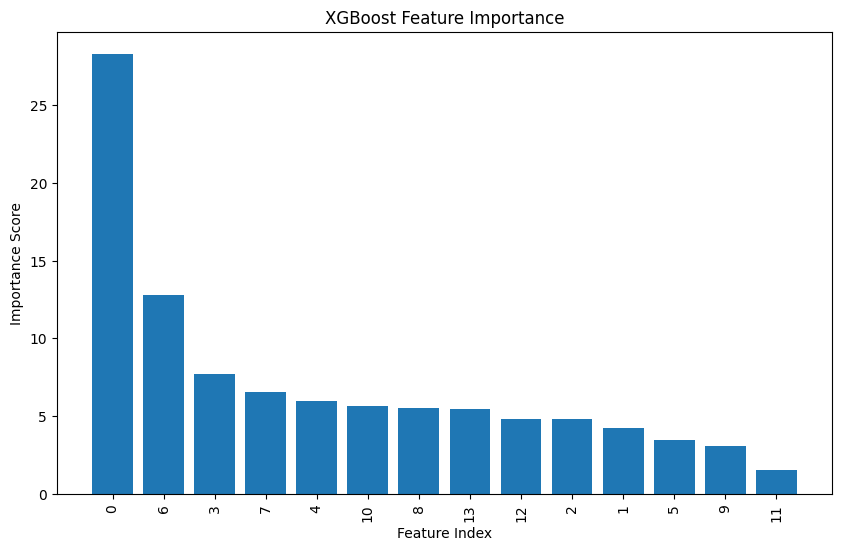

In [21]:
importances = model.feature_importances_

# Sort and visualize
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), indices, rotation=90)  # Using indices instead of feature names
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('CatBoost Feature Importance')
plt.show()

In [22]:
idx_to_remove = [11]
X_train_new = np.delete(X_train, idx_to_remove, axis=1)
X_test_new = np.delete(X_test, idx_to_remove, axis=1)
print(f"New Dimension : {X_train_new.shape}\nNew Dimension (testset): {X_test_new.shape}")

New Dimension : (20631, 13)
New Dimension (testset): (13096, 13)


#### Training : after feature analysis

In [23]:
X_train_fa, X_val_fa, y_train_fa, y_val_fa = train_test_split(X_train_new, y_train, test_size=0.30, random_state=7)

model = CatBoostClassifier(iterations=100,
                           loss_function="MultiClass",
                           classes_count=3,
                           verbose=False)

# Fit model on training data
model.fit(X_train_fa, y_train_fa)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      3699
           1       0.70      0.70      0.70      1247
           2       0.90      0.86      0.88      1244

    accuracy                           0.88      6190
   macro avg       0.84      0.84      0.84      6190
weighted avg       0.88      0.88      0.88      6190

 Mean Absolute Error (MAE): 0.12
 Root Mean Squared Error (RMSE): 0.35
 R2 Score: 0.81
<)-------------X-------------(>


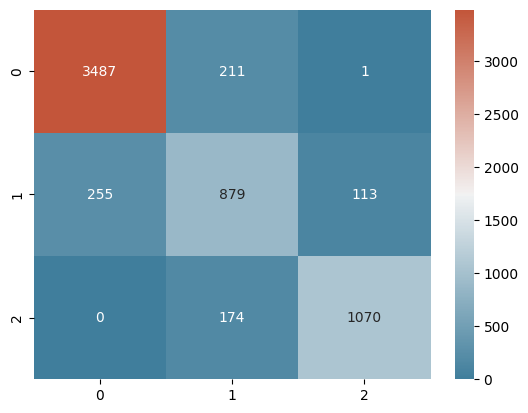

In [24]:
y_pred_fa1 = model.predict(X_val_fa)
 
# Evaluate the model & print metrics
plot_confmatrix(y_val_fa,y_pred_fa1)
score_func(y_val_fa,y_pred_fa1)

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.99      0.83      7797
           1       0.33      0.22      0.27      2620
           2       0.95      0.18      0.30      2679

    accuracy                           0.67     13096
   macro avg       0.66      0.47      0.47     13096
weighted avg       0.69      0.67      0.61     13096

 Mean Absolute Error (MAE): 0.41
 Root Mean Squared Error (RMSE): 0.75
 R2 Score: 0.12
<)-------------X-------------(>


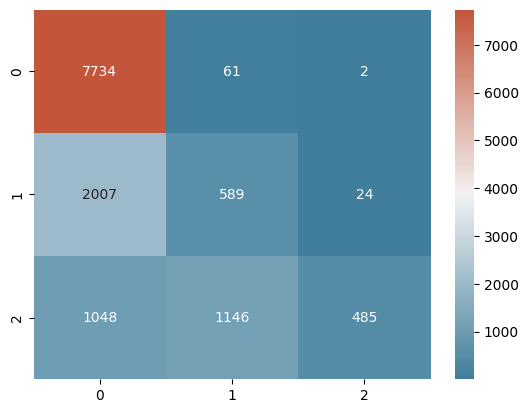

In [25]:
y_pred_fa2 = model.predict(X_test_new)
 
# Evaluate the model & print metrics
plot_confmatrix(y_test,y_pred_fa2)
score_func(y_test,y_pred_fa2)

### Hyperparameter Tuning

In [26]:
# Define hyperparameter space for CatBoost

param_dist_catboost = {
    'iterations': [64, 128],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [0.001,0.05, 0.01, 0.1],
    'loss_function':["MultiClass"],
    'verbose':[False],
    'auto_class_weights': ['SqrtBalanced','Balanced','None']
}

# Create CatBoost model
catboost_model = CatBoostClassifier()

# Perform RandomizedSearchCV for CatBoost
random_search_catboost = RandomizedSearchCV(
    catboost_model, param_distributions=param_dist_catboost,
    n_iter=10, cv=5, scoring='f1_macro', random_state=7, verbose=1, n_jobs=-1)

random_search_catboost.fit(X_train_new, y_train)

# Access the best CatBoost model
best_catboost = random_search_catboost.best_estimator_
print("Best Hyperparameters for CatBoost:", random_search_catboost.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for CatBoost: {'verbose': False, 'loss_function': 'MultiClass', 'learning_rate': 0.01, 'l2_leaf_reg': 0.01, 'iterations': 128, 'depth': 10, 'auto_class_weights': 'SqrtBalanced'}


In [27]:
X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(X_train_new, y_train, test_size=0.30, random_state=7)

In [28]:
model = CatBoostClassifier(iterations=128,
                           learning_rate = 0.05,
                           loss_function="MultiClass",
                           classes_count=3,
                           l2_leaf_reg=0.01,
                           depth=10,
                           auto_class_weights='SqrtBalanced',
                           verbose=False)

# Fit model on training data
model.fit(X_train_hp, y_train_hp)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      3699
           1       0.69      0.78      0.73      1247
           2       0.92      0.88      0.90      1244

    accuracy                           0.89      6190
   macro avg       0.85      0.86      0.86      6190
weighted avg       0.89      0.89      0.89      6190

 Mean Absolute Error (MAE): 0.11
 Root Mean Squared Error (RMSE): 0.34
 R2 Score: 0.82
<)-------------X-------------(>


<Axes: >

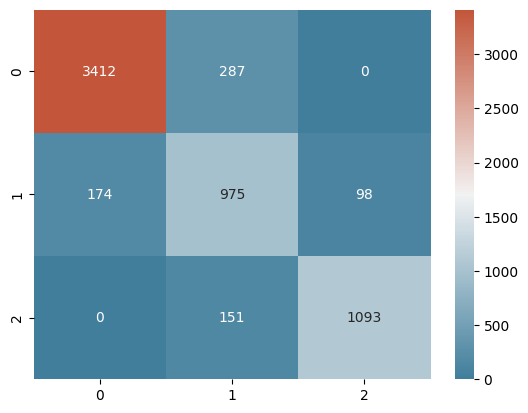

In [30]:
y_pred_hp1 = model.predict(X_val_hp)
 
# Evaluate the model & print metrics
score_func(y_val_hp,y_pred_hp1)

plot_confmatrix(y_val_hp,y_pred_hp1)

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85      7797
           1       0.34      0.29      0.31      2620
           2       0.97      0.18      0.30      2679

    accuracy                           0.68     13096
   macro avg       0.68      0.48      0.48     13096
weighted avg       0.71      0.68      0.63     13096

 Mean Absolute Error (MAE): 0.38
 Root Mean Squared Error (RMSE): 0.72
 R2 Score: 0.21
<)-------------X-------------(>


<Axes: >

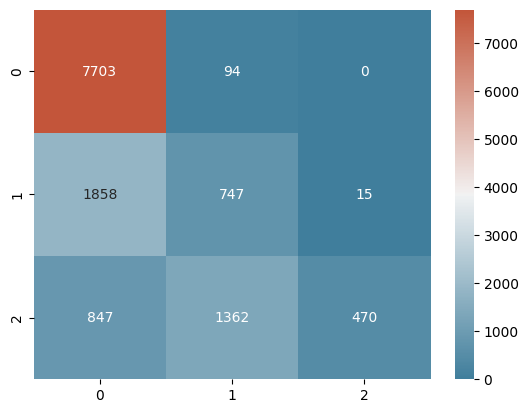

In [31]:
y_pred_hp2 = model.predict(X_test_new)
 
# Evaluate the model & print metrics
score_func(y_test,y_pred_hp2)

plot_confmatrix(y_test,y_pred_hp2)